In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashrunwal","key":"bad849ef2d9b4ae03efd5935f34ad6dd"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d shobhit18th/indian-currency-notes

 95% 277M/290M [00:07<00:00, 37.1MB/s]
100% 290M/290M [00:07<00:00, 39.0MB/s]


In [0]:
Dataset = !unzip indian-currency-notes.zip

In [22]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 19kB/s 
     |████████████████████████████████| 4.0MB 37.3MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from fastai.vision import *
from fastai import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
path = Path('/content/indian_currency_new')
path.ls()

[PosixPath('/content/indian_currency_new/validation'),
 PosixPath('/content/indian_currency_new/training')]

In [4]:
# Create a DataBunch
data = ImageDataBunch.from_folder(path, train='training', valid='validation', no_check=True, size=64)
print(data.classes);print(data.c)

['10', '100', '20', '200', '2000', '50', '500', 'Background']
8


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.722343,1.680253,0.575916,0.424084,00:59
1,1.745199,0.898896,0.319372,0.680628,00:56
2,1.267630,0.500611,0.151832,0.848168,00:56
3,0.993894,0.405453,0.115183,0.884817,00:56


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


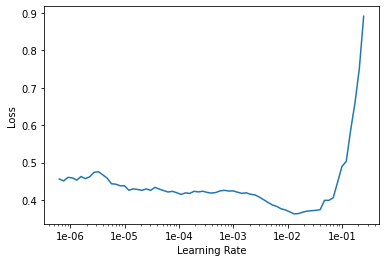

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.423905,0.369166,0.099476,0.900524,00:56
1,0.389337,0.496004,0.115183,0.884817,00:56
2,0.384853,0.417955,0.104712,0.895288,00:57
3,0.328645,0.317112,0.094241,0.905759,00:56


In [13]:
interp = ClassificationInterpretation.from_learner(learn)

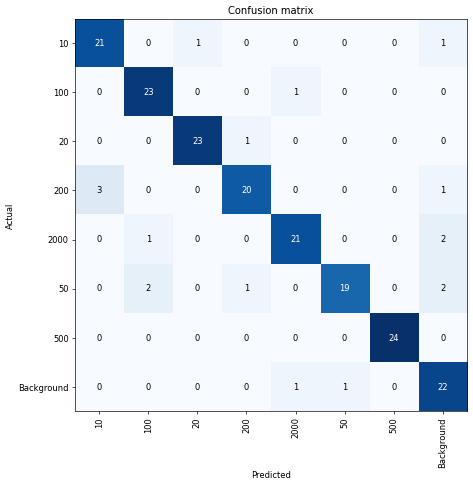

In [16]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [0]:
learn.save('notes-classification-resnet34-stage-1')

# **Predicting a Single Image**

In [0]:
import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json

In [0]:
def fetch_image(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

In [0]:
def predict(url):
    img = fetch_image(url)
    pred_class,pred_idx,outputs = learn.predict(img)
    res =  zip (learn.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    pprint.pprint( top_predictions)
    return img.resize(500)

# **10 Rupee Note**

[('10', 0.5495107173919678),
 ('50', 0.4169573485851288),
 ('20', 0.03180889040231705),
 ('Background', 0.0011988694313913584),
 ('200', 0.00032284000189974904)]


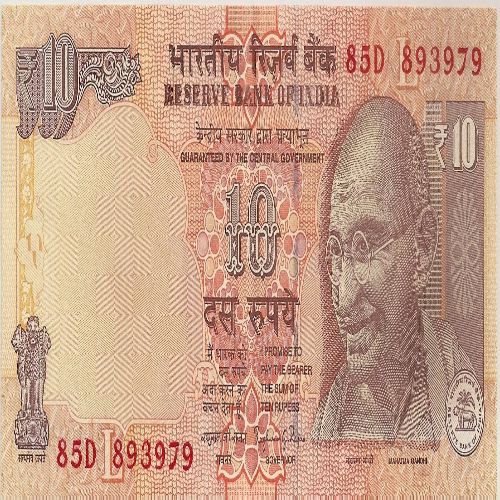

In [24]:
Note10_url = 'https://hi-static.z-dn.net/files/d60/1ca6e2f8ea8090c979600b88438ec602.jpg'
predict(Note10_url)

# **20 Rupee Note**

[('20', 0.9995203018188477),
 ('10', 0.000228400036576204),
 ('100', 0.000171281149960123),
 ('Background', 2.688751192181371e-05),
 ('50', 2.01866751012858e-05)]


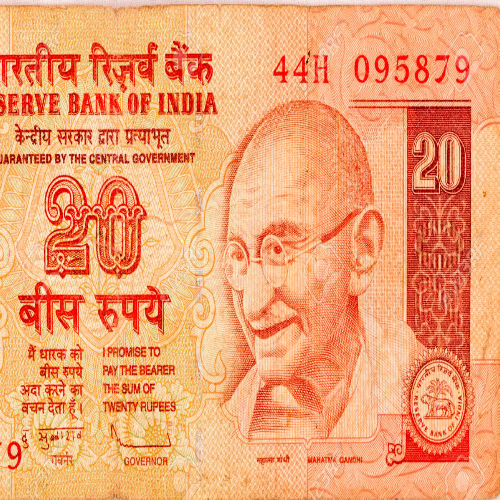

In [38]:
Note20_url = 'https://previews.123rf.com/images/gesrey/gesrey1803/gesrey180300005/98556961-close-up-20-indian-rupee-frontside-with-mahatma-gandhi-background.jpg'
predict(Note20_url)

# **50 Rupee Note**

[('50', 0.9999992847442627),
 ('100', 6.597580863854091e-07),
 ('200', 4.567818567835502e-09),
 ('20', 1.3503244078449939e-09),
 ('500', 1.0046902199079e-09)]


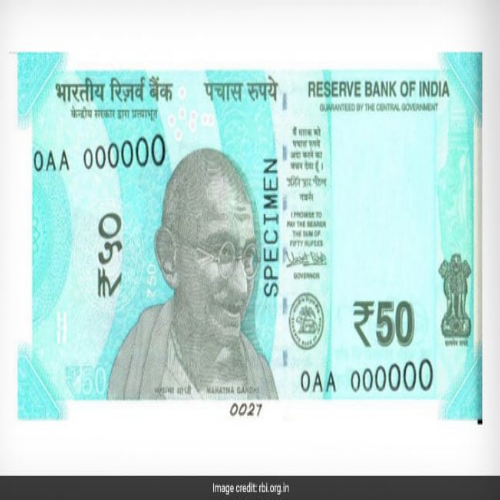

In [28]:
Note50_url = 'https://i.ndtvimg.com/i/2017-08/rs-50-rbi_650x400_71503068441.jpg'
predict(Note50_url)

# **100 Rupee Note**

[('100', 0.9959865212440491),
 ('2000', 0.003870436456054449),
 ('Background', 0.00010249480692436919),
 ('50', 2.4778446459094994e-05),
 ('500', 5.771568339696387e-06)]


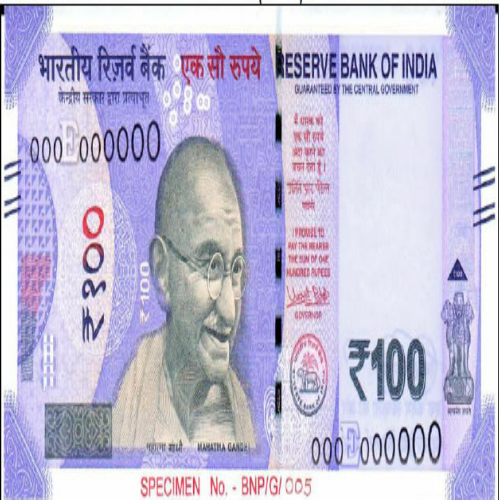

In [39]:
Note100_url = 'https://upload.wikimedia.org/wikipedia/commons/8/88/India_new_100_INR%2C_Mahatma_Gandhi_New_Series%2C_2018%2C_obverse.png'
predict(Note100_url)

# **Deploying the Model to Production**

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

In [0]:
learn = load_learner(path)

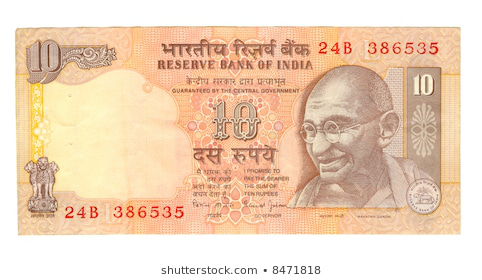

In [52]:
img = open_image(path/'training'/'10'/'1.jpg')
img

In [53]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category 10

In [0]:
with open('/content/indian_currency_new/models/classes.txt', 'w') as f:
    json.dump(learn.data.classes,f)